# Example Notebook for Keysight Network Analyzers

This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight network analyzers. The driver is implemented to be generic as possible, with individual instrument drivers filling in only the hardware limits of the instrument, so although this example uses the N5245A or N5222B, the concepts and code should work for any keysight network analyzer.

In [1]:
%matplotlib inline

In [2]:
# Import Dependencies

import logging
import matplotlib.pyplot as plt

# qcodes imports
import qcodes as qc
from qcodes.dataset.experiment_container import new_experiment, load_experiment_by_name
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument_drivers.Keysight.N5245A import N5245A 
from qcodes.instrument_drivers.Keysight.N5222B import N5222B

#setup
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Start experiment
exp_name = 'PNA_Example'
sample_name = 'Thru_Coax'
try:
    exp = load_experiment_by_name(exp_name, sample=sample_name)
    print('Experiment loaded. Last ID no:', exp.last_counter)
except ValueError:
    exp = new_experiment(exp_name, sample_name)
    print('Starting new experiment.')

Experiment loaded. Last ID no: 48


## Connect to the instrument

You will have to insert the correct VISA address for your PNA below. Two examples are given below. Uncomment the appropriate line 

In [3]:
#pna = N5245A('pna', 'TCPIP::192.168.0.10::inst0::INSTR')
pna = N5222B('pna', 'GPIB0::16::INSTR')

Connected to: Keysight Technologies N5225B (serial:MY57181138, firmware:A.12.85.04) in 0.25s


In [4]:
def reset_instrument(): 
    # Start over: delete all traces, channels and windows 

    pna.delete_all_traces()

    for window in pna.window: 
        window.delete()

    for channel in pna.channel: 
        channel.delete()

## Simple Measurements

We can very easily set up measurements and pull, for example, magnitude data off the PNA. A channel to add a trace will automatically be added 

In [5]:
reset_instrument()

In [6]:
fstart = 10e6  # Hz
fstop = 18e9 # Hz 
points = 1001
power = 10 # dB

In [24]:
# We add two traces and later select one for a measurement. It does not matter how the traces got on the instrument, either 
# programmatically or manually through the instrument display
pna.add_trace("S21") 
pna.add_trace("S22") 

<Trace Type: S22>

Starting experimental run with id: 118


([<matplotlib.axes._subplots.AxesSubplot at 0x149f382d400>], [None])

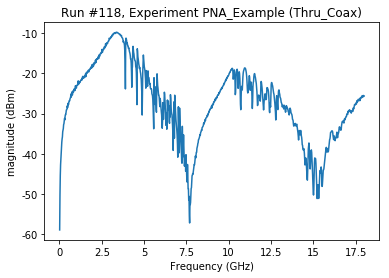

In [22]:
# Set up a frequency sweep from 100 MHz to 1 GHz, with 1001 points, at a power of -40dBm
pna.power(power)
pna.start(fstart)
pna.stop(fstop)
pna.points(points)
pna.trace("S21")  # Select on of the created traces. If no trace "S21" exists, one will be created. It is thus not necessary to 
# Run the cell above this one. 

# Enable 2 averages, and set IF BW to 1kHz
pna.if_bandwidth(1e3)
pna.averages_enabled(True)
pna.averages(2) # alternatively, we can give the number of averages when calling "run_sweep"

# Run a measurement
meas = Measurement()
meas.register_parameter(pna.magnitude)

with meas.run() as datasaver:
    pna.run_sweep()  # Unlike with the previous driver, there is no "auto_sweep", so we *always* explicitely 
    # call 'run_sweep'
    
    mag = pna.magnitude()
    datasaver.add_result((pna.magnitude, mag))
    dataid = datasaver.run_id
plot_by_id(dataid)

In [25]:
pna.traces

[<Trace Type: S21>, <Trace Type: S22>]

## Simple measurements, the complicated way 

Alternatively, we can add a channel to manually and add the channel to a window. This is more verbose but allows us to add traces to more then one channel  

In [8]:
reset_instrument()

Starting experimental run with id: 117


([<matplotlib.axes._subplots.AxesSubplot at 0x149f16df940>], [None])

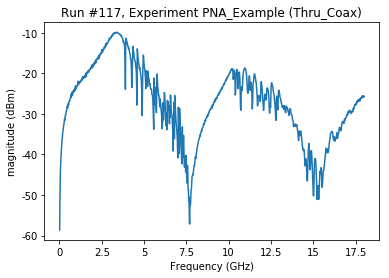

In [9]:
window = pna.add_window()
channel = pna.add_channel()

trace_s21 = channel.add_trace("S21")  
window.add_channel(channel) # This will make our trace show up on the instrument display 

channel.power(power)
channel.start(fstart)
channel.stop(fstop)
channel.points(points)

# Enable 2 averages, and set IF BW to 1kHz
channel.if_bandwidth(1e3)
channel.averages_enabled(True)
channel.averages(2)

meas = Measurement()
meas.register_parameter(trace_s21.magnitude)

with meas.run() as datasaver:
    channel.run_sweep()
    
    mag = trace_s21.magnitude()
    datasaver.add_result((trace_s21.magnitude, mag))
    dataid = datasaver.run_id
plot_by_id(dataid)

### What is going on behind the scenes

Measurement traces always belong to channels. In the previous driver, the channel was always assumed to be channel 1; this was hard coded. The new driver is more flexible and can add traces to other channels. 

For backward compatibility, whenever we access a channel attribute, such as `power`, `start` or `stop` and no channel has been created yet on the instrument, a channel is created on the fly. 

In [10]:
reset_instrument()

In [11]:
pna.channel  # There should be no channels 

[]

In [12]:
pna.power(power) # This will implicitely create a channel and set its power correctly 

In [13]:
pna.channel  # One channel should have been added 

[<Channel type <N5222B: pna>: 1>]

In [19]:
pna.selected_channel is pna.channel[0]  # Ways we can access the implicitely created channel 

True

In [18]:
pna.selected_channel.power() == power

True

With other words, `pna.power(power), channel=pna.selected_channel` is equivalent to `channel = pna.add_channel(), channel.power(power)`. This maintains backward compatibility with the old way of working 

## Multiple Traces

We can also read multiple traces off the PNA at once. For example if the PNA is set up such that:
 - Trace 1 is S21
 - Trace 2 is S11
 - Trace 3 is S12
 - Trace 4 is S22
 
we can read these off simultaneously as follows:

In [26]:
# We can set the PNA up manually, but here we decide to define them programatically
# If we do this manually, please add the traces on the correct channel 
pna.add_trace("S21")
pna.add_trace("S11")
pna.add_trace("S12")
pna.add_trace("S22")

<Trace Type: S22>

In [27]:
pna.traces

[<Trace Type: S21>, <Trace Type: S22>, <Trace Type: S11>, <Trace Type: S12>]

Starting experimental run with id: 119


([<matplotlib.axes._subplots.AxesSubplot at 0x149f49a2f60>,
 [None, None, None, None])

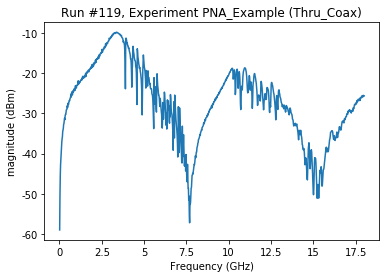

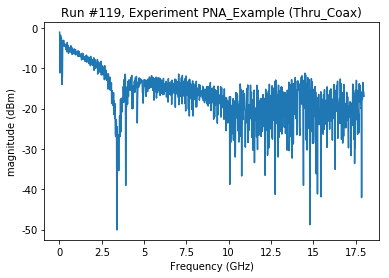

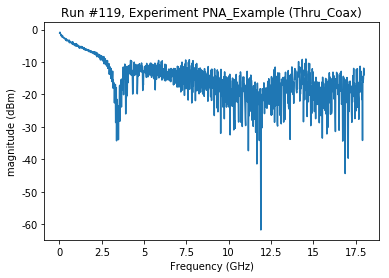

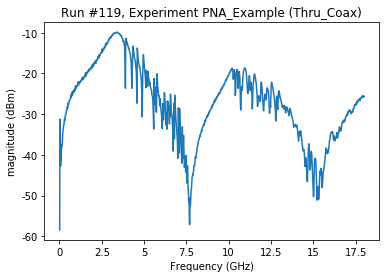

In [28]:
# Update the list of traces
traces = pna.traces

# Run a measurement
meas = Measurement()

meas.register_parameter(traces[0].magnitude) # Note: The new driver does not have an interface 'pna.traces.tr1' etc. 
meas.register_parameter(traces[1].magnitude)
meas.register_parameter(traces[2].magnitude)
meas.register_parameter(traces[3].magnitude)

with meas.run() as datasaver:
    pna.run_sweep() # Ask the PNA to take a measurement
    data = []
    for trace in traces:
        mag = trace.magnitude()
        data.append((trace.magnitude, mag))
    datasaver.add_result(*data)
    dataid = datasaver.run_id
plot_by_id(dataid)

In [15]:
# Set the PNA back into continuous sweep mode
pna.sweep_mode("CONT")